##Data Preparation and Cleaning

* Web scraping to get resumes and create a CSV file with all resumes scrapped

In [ ]:
!apt-get update
!apt install chromium-chromedriver
!pip install selenium beautifulsoup4

import warnings
import logging
import sys
import os

# Suppress Python warnings
warnings.filterwarnings('ignore')

# Suppress logging messages
logging.disable(logging.CRITICAL)

import sys
sys.path.insert(0, '/usr/lib/chromium-browser/chromedriver')

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup

import re
import csv
import time
import re
import requests
import random

import pandas as pd
import numpy as np

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,159 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran4

In [ ]:
base_url = "https://www.hireitpeople.com/resume-database/64-java-developers-architects-resumes"

# Generate all URLs
urls = [base_url]  # page 1 url
urls += [f"{base_url}/page/{i}" for i in range(2, 61)]  # pages 2 to 60 url

resume_links = []

for url in urls:
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    # Find all <a> tags inside the resume table
    table_rows = soup.select("table.hit-table tbody tr")
    for row in table_rows:
        a_tag = row.find("a", href=True)
        if a_tag:
            resume_links.append(a_tag['href'])

# Save all links to CSV
with open("resume_links.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    for link in resume_links:
        writer.writerow([link])

In [ ]:
# Setup headless Selenium
options = Options()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
driver = webdriver.Chrome(options=options)

# Read links from resume_links.csv
with open("resume_links.csv", "r", encoding="utf-8") as f:
    reader = csv.reader(f)
    urls = [row[0] for row in reader]

# Open CSV to save summaries
with open("resumes.csv", "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["URL", "Resume Summary"])  # header

    for url in urls:
        driver.get(url)
        time.sleep(2)  # wait for page to load
        soup = BeautifulSoup(driver.page_source, "html.parser")
        text = soup.get_text(separator="\n")

        # Extract summary only between "Hire Now" button at the top and "Hire Now" button at the end
        match = re.search(r"Hire Now(.*?)Hire Now", text, re.DOTALL | re.IGNORECASE)
        if match:
            resume_section = match.group(1).strip()
            resume_section = re.sub(r"\s+", " ", resume_section)
        else:
            resume_section = "Section not found"

        writer.writerow([url, resume_section])

driver.quit()


KeyboardInterrupt: 

* Clean data by dropping resumes with "Professional Summary" section to ensure consistency in data set

In [ ]:
# Load CSV file
df = pd.read_csv("/content/resumes.csv")

# Find entries with "Professional Summary" section
matches = df[df["Resume Summary"].astype(str).str.contains("Professional Summary", na=False)]

# Convert to CSV file
matches.to_csv("matches.csv", index=False, encoding="utf-8")

FileNotFoundError: [Errno 2] No such file or directory: '/content/resumes.csv'

* Split "Resume Summary" column into "Summary", "Technical Skills" and "Professional Experience"

In [ ]:
# Load CSV file
df = pd.read_csv("/content/resumes.csv")

# Filter entries with "Professional Summary" section
df = df[~df["Resume Summary"].isin(matches["Resume Summary"])]

# Drop duplicated entries from dataframe
df.to_csv("resumes_cleaned.csv", index=False, encoding="utf-8")

# Define function to split "Resume Summary" into 3 columns
def extract_sections(text):
    text = str(text)

    # Summary
    summary_match = re.search(
        r'SUMMARY(.*?)(TECHNICAL\s*SKILLS|PROFESSIONAL\s*EXPERIENCE|$)',
        text, re.DOTALL | re.IGNORECASE
    )
    summary = summary_match.group(1).strip() if summary_match else ""

    # Technical Skills
    tech_match = re.search(
        r'TECHNICAL\s*SKILLS(.*?)(PROFESSIONAL\s*EXPERIENCE|$)',
        text, re.DOTALL | re.IGNORECASE
    )
    technical_skills = tech_match.group(1).strip() if tech_match else ""

    # Professional Experience
    exp_match = re.search(
        r'PROFESSIONAL\s*EXPERIENCE(.*)',
        text, re.DOTALL | re.IGNORECASE
    )
    experience = exp_match.group(1).strip() if exp_match else ""

    return pd.Series([summary, technical_skills, experience])

# Apply the function to the column
df[['Summary', 'Technical Skills', 'Professional Experience']] = df['Resume Summary'].apply(extract_sections)

# Save to a new CSV
df.to_csv("resumes_split.csv", index=False, encoding="utf-8")

* Extract number of years of experience and number of past jobs from "Technical Skills" and "Professional Experience" columns

In [ ]:
# Load CSV file
resumes = pd.read_csv("resumes_split.csv")


# Inspecting dataframe
resumes.head()

# Define function to extract number of years of experience from "Summary" column
def extract_years(text):
    match = re.search(r'(\d+\+?)\s*(?:years?|yrs?)\s', str(text), re.IGNORECASE)
    return match.group(1) if match else ""

# Apply function to column
resumes["Years of Experience"] = resumes["Summary"].apply(extract_years)

# Count number of past jobs
def count_jobs(text):
    if pd.isna(text):
        return 0

    # Pattern for job headers
    pattern = r'(?<!\w)(Confidential)(?=[\s]*[,|-])'
    return len(re.findall(pattern, text))

resumes["Number of Past Jobs"] = resumes["Professional Experience"].apply(count_jobs)
resumes.to_csv("resumes_with_years.csv", index=False)

* Add a randomized gender column with "Male" or "Female" values

In [ ]:
# Load CSV file
df = pd.read_csv("/content/resumes_with_years.csv")

# Define possible gender options
genders = ["Male", "Female"]

# Create a new column with random gender assignments
n = len(df)
half = n // 2

genders = ["Male"] * half + ["Female"] * (n - half)
np.random.shuffle(genders)

df["Gender"] = genders
df["Gender"] = np.random.choice(genders, size=len(df))

# Save the updated DataFrame to a new CSV
df.to_csv("resumes_with_gender.csv", index=False)

* Search and count the number of masculine and femine words in each resume

In [ ]:
# Load CSV file
df = pd.read_csv("/content/resumes_with_gender.csv")

# Define prefixes for gender-coded words
masculine_prefixes = [
    'active', 'adventurous', 'aggress', 'ambitio', 'analy', 'assert',
    'athlet', 'autonom', 'battle', 'boast', 'challeng', 'champion',
    'compet', 'confident', 'courag', 'decid', 'decision', 'decisive',
    'defend', 'determin', 'domina', 'dominant', 'driven', 'fearless',
    'fight', 'force', 'greedy', 'head-strong', 'headstrong', 'hierarch',
    'hostil', 'impulsive', 'independen', 'individual', 'intellect',
    'lead', 'logic', 'objective', 'opinion', 'outspoken', 'persist',
    'principle', 'reckless', 'self-confiden', 'self-relian',
    'self-sufficien', 'selfconfiden', 'selfrelian', 'selfsufficien',
    'stubborn', 'superior', 'unreasonab'
]
feminine_prefixes = [
    'agree', 'affectionate', 'child', 'cheer', 'collab', 'commit',
    'communal', 'compassion', 'connect', 'considerate', 'cooperat',
    'co-operat', 'depend', 'emotiona', 'empath', 'feel', 'flatterable',
    'gentle', 'honest', 'interpersonal', 'interdependen', 'interpersona',
    'inter-personal', 'inter-dependen', 'inter-persona', 'kind', 'kinship',
    'loyal', 'modesty', 'nag', 'nurtur', 'pleasant', 'polite', 'quiet',
    'respon', 'sensitiv', 'submissive', 'support', 'sympath', 'tender',
    'together', 'trust', 'understand', 'warm', 'whin', 'enthusias',
    'inclusive', 'yield', 'share', 'sharin'
]

# Define function to detect gender-coded words in the resumes
def detect_gender_prefix_words(text):
    text = str(text).lower()

    masculine_found = []
    for p in masculine_prefixes:
        masculine_found += re.findall(r'\b' + re.escape(p) + r'\w*', text)

    feminine_found = []
    for p in feminine_prefixes:
        feminine_found += re.findall(r'\b' + re.escape(p) + r'\w*', text)

    return pd.Series([masculine_found, feminine_found])

# Apply to resume text column
df[['Masculine Words', 'Feminine Words']] = df['Resume Summary'].apply(detect_gender_prefix_words)

# Count the number of masculine and feminine words
df['Masculine Count'] = df['Masculine Words'].apply(len)
df['Feminine Count'] = df['Feminine Words'].apply(len)

# Convert to a new CSV file
df.to_csv("resumes_with_gender_words.csv", index=False)


* Join datasets

In [ ]:
# Load CSV files to join
left_df = pd.read_csv("resumes_with_gender.csv")
right_df = pd.read_csv("resumes_with_gender_words.csv")

# Left join on URL column
merged_df = pd.merge(left_df, right_df, on='URL', how='left')

# Save the merged CSV
merged_df.to_csv("resumes_latest_ver.csv", index=False)

merged_df.info()

FileNotFoundError: [Errno 2] No such file or directory: 'resumes_with_gender.csv'

## Data Visualization

In [ ]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

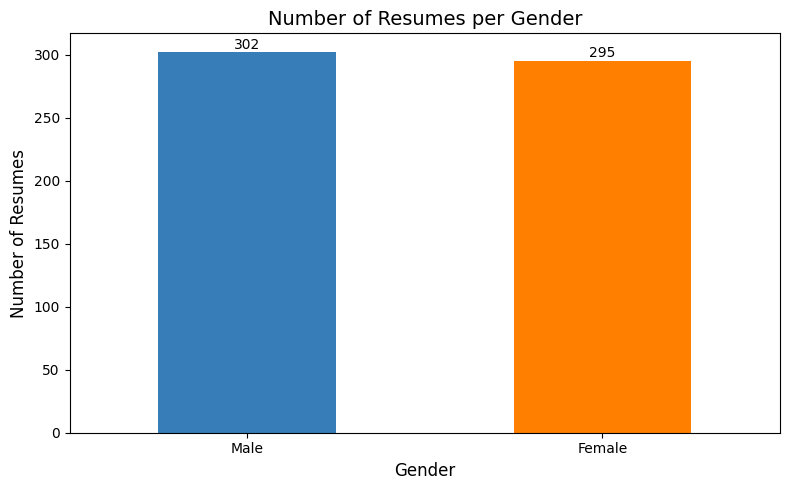

In [ ]:
resumes = pd.read_csv("/content/sample_data/resumes_latest_ver (2).csv")

gender_counts = resumes['Gender'].value_counts()

# Plot a bar chart
plt.figure(figsize=(8, 5))
gender_counts.plot(kind='bar', color=['#377eb8', '#ff7f00'])

# Add labels and title
plt.title("Number of Resumes per Gender", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Number of Resumes", fontsize=12)
plt.xticks(rotation=0)

# Add value labels on bars
for i, count in enumerate(gender_counts):
    plt.text(i, count + (0.01 * gender_counts.max()), str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


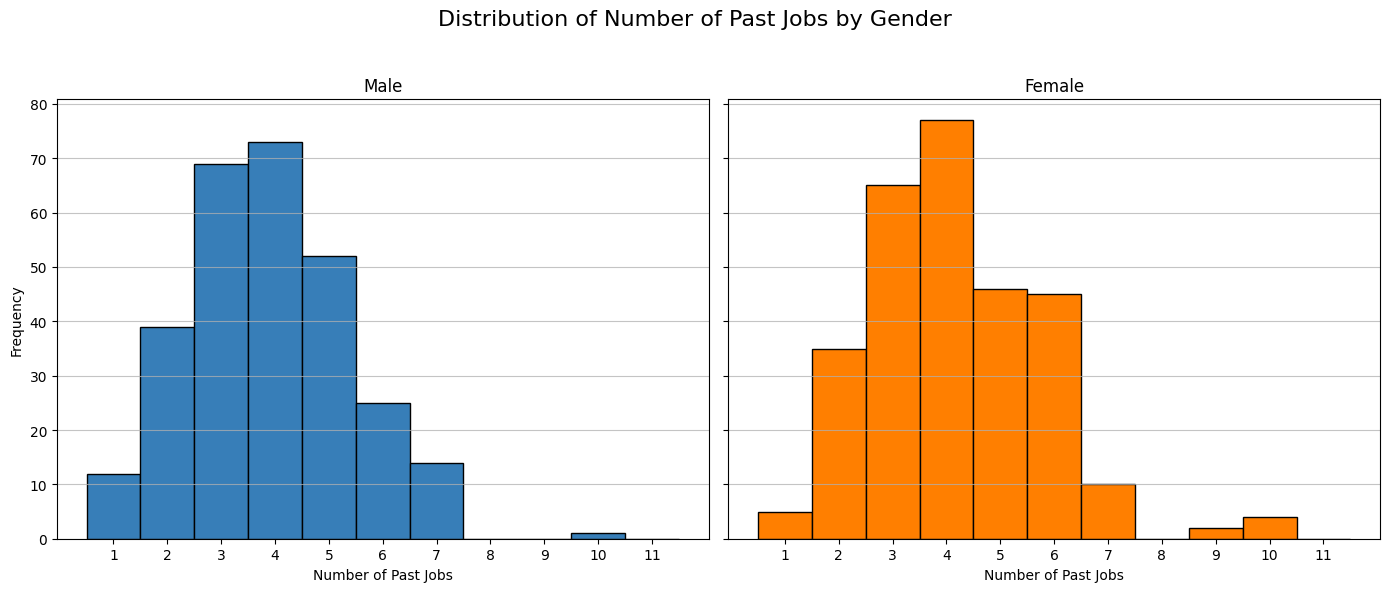

In [ ]:
bins = np.arange(0.5, 12.5, 1)

# Separate data by gender
female_jobs = resumes[resumes['Gender'] == 'Female']['Number of Past Jobs'].dropna()
male_jobs = resumes[resumes['Gender'] == 'Male']['Number of Past Jobs'].dropna()

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Male histogram on the LEFT
axes[0].hist(male_jobs, bins=bins, color='#377eb8', edgecolor='black')
axes[0].set_title('Male')
axes[0].set_xlabel('Number of Past Jobs')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(np.arange(1, 12, 1))
axes[0].grid(axis='y', alpha=0.75)

# Female histogram on the RIGHT
axes[1].hist(female_jobs, bins=bins, color='#ff7f00', edgecolor='black')
axes[1].set_title('Female')
axes[1].set_xlabel('Number of Past Jobs')
axes[1].set_xticks(np.arange(1, 12, 1))
axes[1].grid(axis='y', alpha=0.75)

# Main title
fig.suptitle('Distribution of Number of Past Jobs by Gender', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



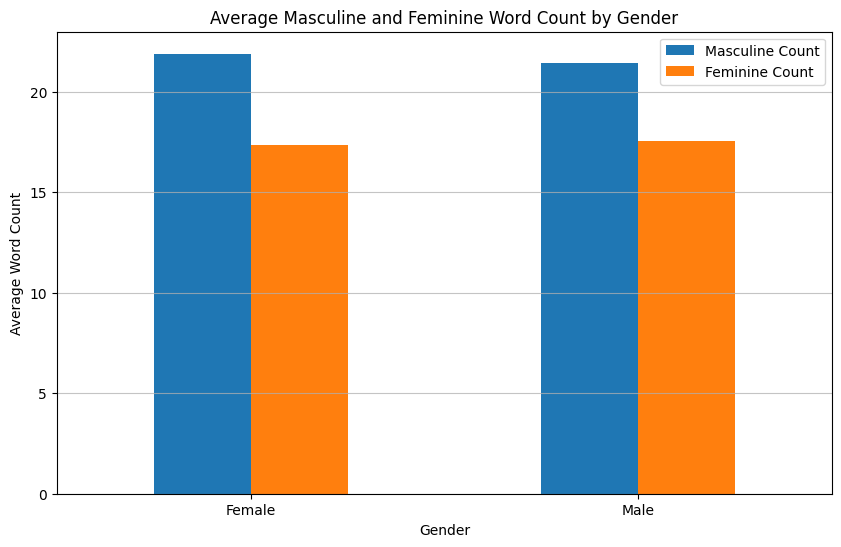

In [ ]:
# Group by gender and calculate the mean of masculine and feminine word counts
gender_word_counts = resumes.groupby('Gender')[['Masculine Count', 'Feminine Count']].mean()

# Plot a grouped bar chart
gender_word_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Average Masculine and Feminine Word Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Word Count')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
resumes['Technical Skills'] = resumes['Technical Skills'].fillna('').str.lower()
resumes['Technical Skills'] = resumes['Technical Skills'].str.split(r'[,;/\n]')
skills_df = resumes.explode('Technical Skills')
skills_df['Technical Skills'] = skills_df['Technical Skills'].str.strip()

In [ ]:
gender_skill_counts = skills_df.groupby(['Gender', 'Technical Skills']).size().reset_index(name='Skill Count')
display(gender_skill_counts.head())

,Gender,Technical Skills,Skill Count
0,Female,,22
1,Female,(internet explorer) database: pl,1
2,Female,(kintana),2
3,Female,.net,1
4,Female,.net tools:,1


In [ ]:
# Identify the top N technical skills (let's choose N=20 for example)
top_skills = gender_skill_counts.groupby('Technical Skills')['Skill Count'].sum().sort_values(ascending=False).head(20).index.tolist()

# Filter the gender_skill_counts DataFrame to include only the top N skills
filtered_gender_skill_counts = gender_skill_counts[gender_skill_counts['Technical Skills'].isin(top_skills)]

# Pivot the filtered DataFrame
pivoted_skills = filtered_gender_skill_counts.pivot(index='Technical Skills', columns='Gender', values='Skill Count').fillna(0)

# Reset the index
pivoted_skills = pivoted_skills.reset_index()

display(pivoted_skills)

Gender,Technical Skills,Female,Male
0,ajax,122,133
1,c,85,106
2,c++,113,123
3,css,134,137
4,ejb,89,88
5,hibernate,80,90
6,html,98,109
7,javascript,130,163
8,jdbc,114,150
9,jms,85,100


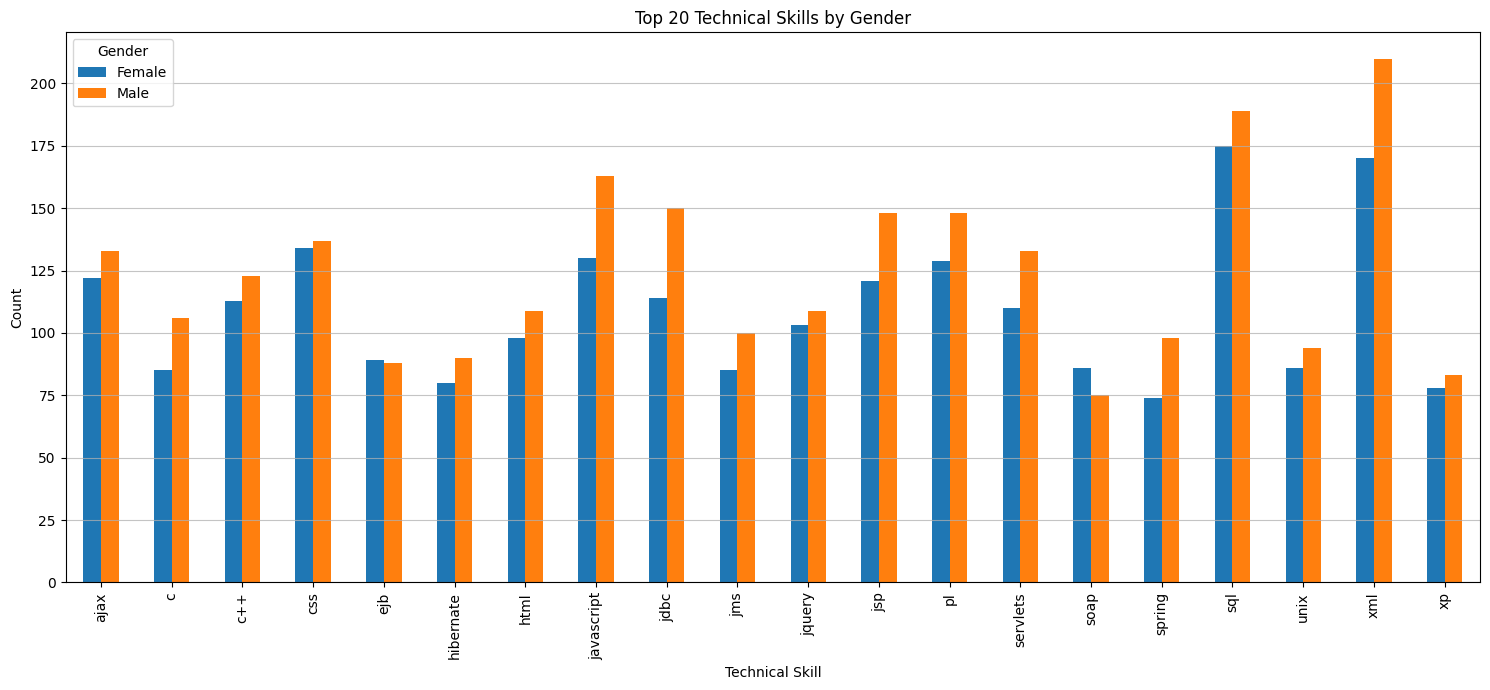

In [ ]:
pivoted_skills.plot(x='Technical Skills', y=['Female', 'Male'], kind='bar', figsize=(15, 7))
plt.title('Top 20 Technical Skills by Gender')
plt.xlabel('Technical Skill')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

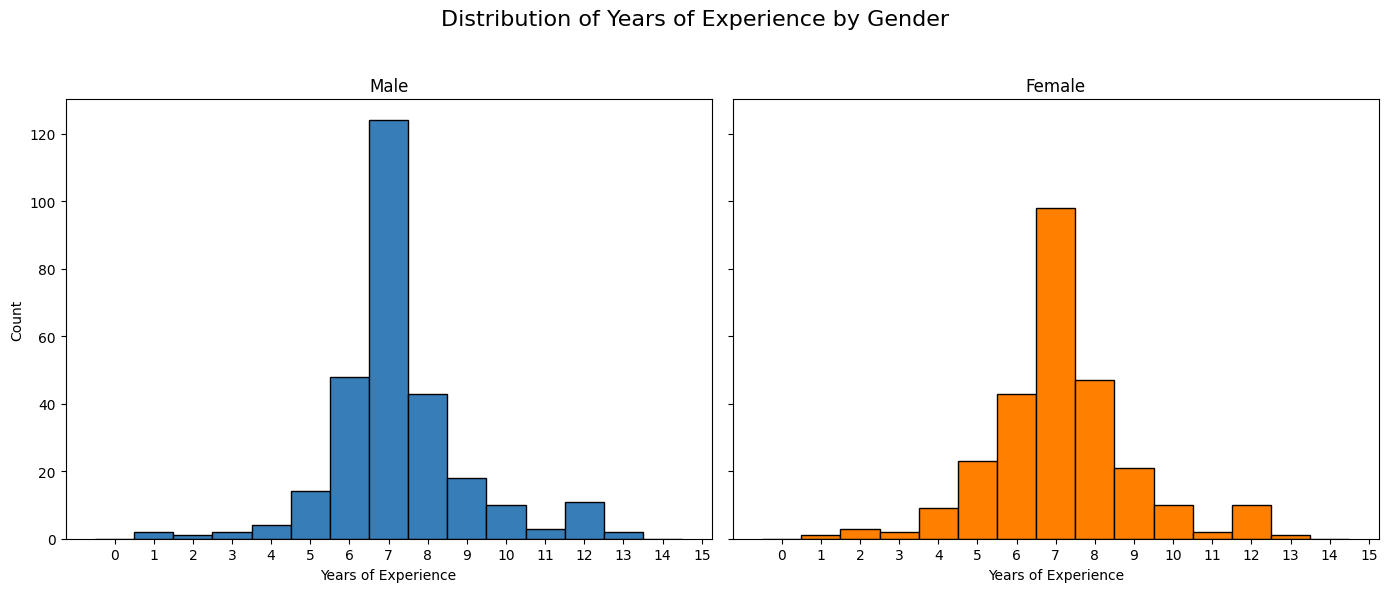

In [ ]:
# Clean the "Years of Experience" column
resumes_cleaned = resumes.copy()
resumes_cleaned["Years of Experience"] = (
    resumes_cleaned["Years of Experience"]
        .str.replace("+", "", regex=False)
        .astype(float)
)

bins = np.arange(0, 16, 1) - 0.5

# Separate data by gender
female_exp = resumes_cleaned[resumes_cleaned["Gender"] == "Female"]["Years of Experience"]
male_exp = resumes_cleaned[resumes_cleaned["Gender"] == "Male"]["Years of Experience"]

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Male histogram on the LEFT
axes[0].hist(male_exp, bins=bins, color='#377eb8', edgecolor='black')
axes[0].set_title('Male')
axes[0].set_xlabel('Years of Experience')
axes[0].set_ylabel('Count')
axes[0].set_xticks(np.arange(0, 16, 1))

# Female histogram on the RIGHT
axes[1].hist(female_exp, bins=bins, color='#ff7f00', edgecolor='black')
axes[1].set_title('Female')
axes[1].set_xlabel('Years of Experience')
axes[1].set_xticks(np.arange(0, 16, 1))

# Main title
fig.suptitle('Distribution of Years of Experience by Gender', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



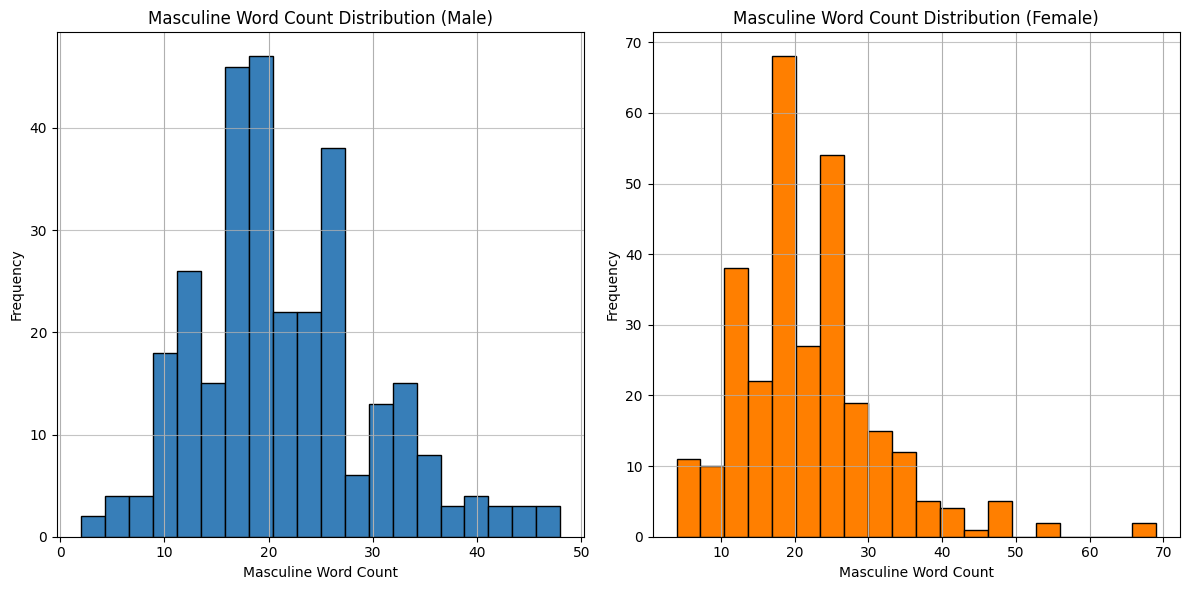

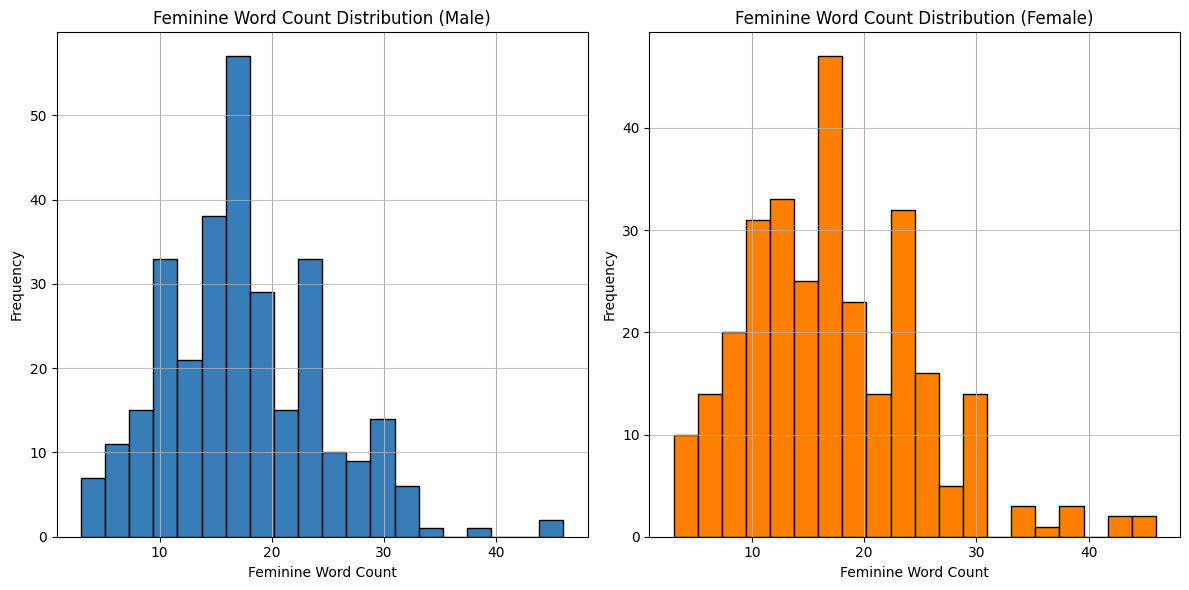

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
resumes[resumes['Gender'] == 'Male']['Masculine Count'].hist(bins=20, edgecolor='black', color = "#377eb8")
plt.title('Masculine Word Count Distribution (Male)')
plt.xlabel('Masculine Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.subplot(1, 2, 2)
resumes[resumes['Gender'] == 'Female']['Masculine Count'].hist(bins=20, edgecolor='black', color = "#ff7f00")
plt.title('Masculine Word Count Distribution (Female)')
plt.xlabel('Masculine Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
resumes[resumes['Gender'] == 'Male']['Feminine Count'].hist(bins=20, edgecolor='black', color = "#377eb8")
plt.title('Feminine Word Count Distribution (Male)')
plt.xlabel('Feminine Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.subplot(1, 2, 2)
resumes[resumes['Gender'] == 'Female']['Feminine Count'].hist(bins=20, edgecolor='black', color = "#ff7f00")
plt.title('Feminine Word Count Distribution (Female)')
plt.xlabel('Feminine Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

## Model

In [ ]:
from __future__ import annotations
import os, re
import numpy as np
import pandas as pd
from typing import List, Tuple, Optional
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ===== Paths (fixed to your request) =====
RESUME_CSV = "/content/sample_data/resumes_latest_ver (2).csv"
OUTPUT_CSV = "/content/sample_data/java_rank_resumes.csv"

# ===== Weights =====
w_sem = 0.70  # how semantically similar the applicant's resume is to job description
w_exp = 0.20  # how mnay years of experience
w_jobs = 0.10 # how many jobs applicant has had

# ===== Java JD =====
JAVA_DEV_JD = (
    "We are seeking a Java Developer with professional experience in Java, Spring or Spring Boot, "
    "RESTful APIs, microservices, SQL/NoSQL databases, and build tools like Maven or Gradle. "
    "Strong skills in unit testing (JUnit), Git, and CI/CD. Experience with Hibernate/JPA, "
    "cloud platforms (AWS, Azure, or GCP), and containerization (Docker, Kubernetes). "
    "Familiarity with messaging (Kafka or RabbitMQ), performance profiling, and Agile teams. "
    "Bonus: frontend (React or Angular)."
)

# ===== Helpers =====

def _clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text
    t = re.sub(r"\S+@\S+", " ", t)
    t = re.sub(r"https?:\/\/\S+", " ", t)
    t = t.replace("C++", " CppPlus ").replace("c++", " CppPlus ")
    t = t.replace("C#", " Csharp ").replace("c#", " Csharp ")
    t = t.replace(".NET", " dotnet ")
    t = re.sub(r"[^A-Za-z0-9\s\+#]", " ", t)
    t = re.sub(r"\s+", " ", t).strip().lower()
    t = t.replace("cppplus", "c++").replace("csharp", "c#")
    return t


def detect_text_column(df: pd.DataFrame) -> Tuple[str, pd.Series]:
    preferred = ["resume", "resume_text", "text", "content", "summary", "profile", "description"]
    for name in preferred:
        for c in df.columns:
            if c.lower() == name:
                return c, df[c].astype(str)
    text_cols = [c for c in df.columns if df[c].dtype == object]
    if not text_cols:
        return "_auto_concat", df.astype(str).agg(" ".join, axis=1)
    avg_lens = {c: df[c].astype(str).str.len().mean() for c in text_cols}
    best = max(avg_lens, key=avg_lens.get)
    return best, df[best].astype(str)


def detect_id_column(df: pd.DataFrame) -> Optional[str]:
    for name in ["candidate_id", "id", "name", "candidate", "user_id"]:
        for c in df.columns:
            if c.lower() == name:
                return c
    return None


def build_tfidf_scores(resume_texts: List[str], jd_text: str) -> np.ndarray:
    corpus = [jd_text] + resume_texts
    vec = TfidfVectorizer(preprocessor=_clean_text, ngram_range=(1, 2), max_features=100_000, stop_words="english")
    X = vec.fit_transform(corpus)
    sims = cosine_similarity(X[1:], X[0])
    return sims.ravel()




def safe_to_float(series: pd.Series) -> np.ndarray:
    def parse_value(x):
        if isinstance(x, (int, float)):
            return float(x)
        if isinstance(x, str):
            x2 = x.replace("+", "").strip()
            try:
                return float(x2)
            except ValueError:
                return np.nan
        return np.nan
    arr = series.apply(parse_value).astype(float).to_numpy()
    arr = np.nan_to_num(arr, nan=0.0)
    return arr


def minmax(x: np.ndarray) -> np.ndarray:
    if x.size == 0:
        return x
    lo, hi = float(np.nanmin(x)), float(np.nanmax(x))
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return np.zeros_like(x, dtype=float)
    return (x - lo) / (hi - lo)


# ===== Main =====

def main():
    if not os.path.exists(RESUME_CSV):
        raise FileNotFoundError(f"CSV not found at {RESUME_CSV}")

    df = pd.read_csv(RESUME_CSV)

    # Text and IDs
    id_col = detect_id_column(df)
    txt_col, series = detect_text_column(df)
    resumes = series.fillna("").astype(str).tolist()

    # Semantic similarity
    sim_tfidf = build_tfidf_scores(resumes, JAVA_DEV_JD)

    semantic = sim_tfidf

    # Find *existing* numeric columns for years/jobs
    exp_col = None
    for c in df.columns:
        cl = c.lower()
        if ("year" in cl and "experience" in cl) or cl in {"years", "experience_years", "years_of_experience"}:
            exp_col = c
            break
    jobs_col = None
    for c in df.columns:
        cl = c.lower()
        if ("job" in cl and ("count" in cl or "number" in cl or "past" in cl)) or cl in {"jobs", "job_count", "number_of_jobs"}:
            jobs_col = c
            break

    # Use them if present; otherwise 0 (we are NOT creating any new columns from text)
    exp_vals = safe_to_float(df[exp_col]) if exp_col is not None else np.zeros(len(df), dtype=float)
    jobs_vals = safe_to_float(df[jobs_col]) if jobs_col is not None else np.zeros(len(df), dtype=float)

    # Normalize for combination
    exp_norm = minmax(exp_vals)
    jobs_norm = minmax(jobs_vals)

    # Final score
    final_score = w_sem * semantic + w_exp * exp_norm + w_jobs * jobs_norm

    # Assemble output (only echoes existing years/jobs columns; no fabricated features)
    out = pd.DataFrame({
        "candidate_id": df[id_col] if id_col else np.arange(len(df)),
        "similarity_tfidf": sim_tfidf,
        "rank_tfidf": pd.Series(sim_tfidf).rank(ascending=False, method="dense").astype(int),
        "final_score": final_score,
        "rank_final": pd.Series(final_score).rank(ascending=False, method="dense").astype(int),
    })

    if exp_col is not None:
        out[exp_col] = df[exp_col]
    if jobs_col is not None:
        out[jobs_col] = df[jobs_col]

    # Pass through gender if present
    for c in df.columns:
        if c.lower() == "gender":
            out["gender"] = df[c]
            break

    out = out.sort_values(["rank_final", "candidate_id"]).reset_index(drop=True)

    os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)
    out.to_csv(OUTPUT_CSV, index=False)

    print("CSV:", RESUME_CSV)
    print("Text column:", txt_col)
    print("ID column:", id_col if id_col else "(index)")
    print("Experience column:", exp_col if exp_col else "(not found)")
    print("Jobs column:", jobs_col if jobs_col else "(not found)")
    print("Saved to:", OUTPUT_CSV)

if __name__ == "__main__":
    main()

CSV: /content/sample_data/resumes_latest_ver (2).csv
Text column: Summary
ID column: (index)
Experience column: Years of Experience
Jobs column: Number of Past Jobs
Saved to: /content/sample_data/java_rank_resumes.csv


70% of the decision = how semantically similar the resume text is to the job description
20% of the decision = how many years of job experience the applicant has (scaled 0-1)
10% of the decision = how mnay past jobs the applicant has had (scaled 0-1)

Data Analysis

In [ ]:
data2 = pd.read_csv("/content/sample_data/java_rank_resumes.csv")
top_50_percent_applicants = data2.nlargest(int(0.5 * len(data2)), 'final_score')


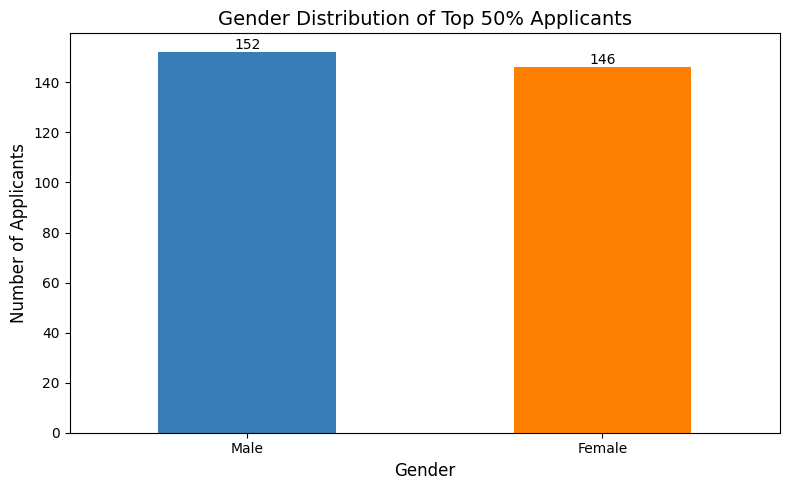

In [ ]:
gender_distribution_top_50 = top_50_percent_applicants['gender'].value_counts()

plt.figure(figsize=(8, 5))
gender_distribution_top_50.plot(kind='bar', color=['#377eb8', '#ff7f00'])

plt.title("Gender Distribution of Top 50% Applicants", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Number of Applicants", fontsize=12)
plt.xticks(rotation=0)

for i, count in enumerate(gender_distribution_top_50):
    plt.text(i, count + (0.01 * gender_distribution_top_50.max()), str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Load CSV file
df = pd.read_csv("/resumes_cleaned.csv")

# Define prefixes for gender-coded words
masculine_prefixes = [
    'active', 'adventurous', 'aggress', 'ambitio', 'analy', 'assert',
    'athlet', 'autonom', 'battle', 'boast', 'challeng', 'champion',
    'compet', 'confident', 'courag', 'decid', 'decision', 'decisive',
    'defend', 'determin', 'domina', 'dominant', 'driven', 'fearless',
    'fight', 'force', 'greedy', 'head-strong', 'headstrong', 'hierarch',
    'hostil', 'impulsive', 'independen', 'individual', 'intellect',
    'lead', 'logic', 'objective', 'opinion', 'outspoken', 'persist',
    'principle', 'reckless', 'self-confiden', 'self-relian',
    'self-sufficien', 'selfconfiden', 'selfrelian', 'selfsufficien',
    'stubborn', 'superior', 'unreasonab'
]
feminine_prefixes = [
    'agree', 'affectionate', 'child', 'cheer', 'collab', 'commit',
    'communal', 'compassion', 'connect', 'considerate', 'cooperat',
    'co-operat', 'depend', 'emotiona', 'empath', 'feel', 'flatterable',
    'gentle', 'honest', 'interpersonal', 'interdependen', 'interpersona',
    'inter-personal', 'inter-dependen', 'inter-persona', 'kind', 'kinship',
    'loyal', 'modesty', 'nag', 'nurtur', 'pleasant', 'polite', 'quiet',
    'respon', 'sensitiv', 'submissive', 'support', 'sympath', 'tender',
    'together', 'trust', 'understand', 'warm', 'whin', 'enthusias',
    'inclusive', 'yield', 'share', 'sharin'
]

# Define function to detect gender-coded words in the resumes
def detect_gender_prefix_words(text):
    text = str(text).lower()

    masculine_found = []
    for p in masculine_prefixes:
        masculine_found += re.findall(r'\b' + re.escape(p) + r'\w*', text)

    feminine_found = []
    for p in feminine_prefixes:
        feminine_found += re.findall(r'\b' + re.escape(p) + r'\w*', text)

    return pd.Series([masculine_found, feminine_found])

# Apply to resume text column
df[['Masculine Words', 'Feminine Words']] = df['Resume Summary'].apply(detect_gender_prefix_words)

# Count the number of masculine and feminine words
df['Masculine Count'] = df['Masculine Words'].apply(len)
df['Feminine Count'] = df['Feminine Words'].apply(len)

# Convert to a new CSV file
df.to_csv("resumes_with_gender_words.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/resumes_cleaned.csv'

In [ ]:
# Load CSV files to join
left_df = pd.read_csv("/resumes_with_years.csv")
right_df = pd.read_csv("resumes_with_gender_words.csv")

# Left join on URL column
merged_df = pd.merge(left_df, right_df, on='URL', how='left')
merged_df = merged_df.drop(columns=["Resume Summary"])

# Save the merged CSV
merged_df.to_csv("resumes_latest_ver.csv", index=False)

merged_df.info()

FileNotFoundError: [Errno 2] No such file or directory: '/resumes_with_years.csv'

In [ ]:
df = pd.read_csv("/content/resumes_latest_ver.csv")

# Assign gender based on counts
def assign_gender(row):
    if row["Masculine Count"] > row["Feminine Count"]:
        return "Male"
    elif row["Masculine Count"] > row["Feminine Count"]:
        return "Female"
    else:
        return np.random.choice(["Male", "Female"])

df["Gender"] = df.apply(assign_gender, axis=1)

# Save results
df.to_csv("resumes_with_gender_nonrandomized.csv", index=False)

# View distribution (optional)
print(df["Gender"].value_counts(normalize=True) * 100)

FileNotFoundError: [Errno 2] No such file or directory: '/content/resumes_latest_ver.csv'

In [ ]:
resumes = pd.read_csv("/content/sample_data/resumes_with_gender_nonrandomized.csv")
gender_counts = resumes['Gender'].value_counts()

# Plot a bar chart
plt.figure(figsize=(8, 5))
gender_counts.plot(kind='bar', color=['#377eb8', '#ff7f00'])

# Add labels and title
plt.title("Number of Resumes per Gender", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Number of Resumes", fontsize=12)
plt.xticks(rotation=0)

# Add value labels on bars
for i, count in enumerate(gender_counts):
    plt.text(i, count + (0.01 * gender_counts.max()), str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_data/resumes_with_gender_nonrandomized.csv'

In [ ]:
from __future__ import annotations
import os, re
import numpy as np
import pandas as pd
from typing import List, Tuple, Optional
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ===== Paths (fixed to your request) =====
RESUME_CSV = "/content/sample_data/resumes_with_gender_nonrandomized.csv"
OUTPUT_CSV = "/content/sample_data/java_rank_resumes.csv"

# ===== Weights =====
w_sem = 0.70  # how semantically similar the applicant's resume is to job description
w_exp = 0.20  # how mnay years of experience
w_jobs = 0.10 # how many jobs applicant has had

# ===== Java JD =====
JAVA_DEV_JD = (
    "We are seeking a Java Developer with professional experience in Java, Spring or Spring Boot, "
    "RESTful APIs, microservices, SQL/NoSQL databases, and build tools like Maven or Gradle. "
    "Strong skills in unit testing (JUnit), Git, and CI/CD. Experience with Hibernate/JPA, "
    "cloud platforms (AWS, Azure, or GCP), and containerization (Docker, Kubernetes). "
    "Familiarity with messaging (Kafka or RabbitMQ), performance profiling, and Agile teams. "
    "Bonus: frontend (React or Angular)."
)

# ===== Helpers =====

def _clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text
    t = re.sub(r"\S+@\S+", " ", t)
    t = re.sub(r"https?:\/\/\S+", " ", t)
    t = t.replace("C++", " CppPlus ").replace("c++", " CppPlus ")
    t = t.replace("C#", " Csharp ").replace("c#", " Csharp ")
    t = t.replace(".NET", " dotnet ")
    t = re.sub(r"[^A-Za-z0-9\s\+#]", " ", t)
    t = re.sub(r"\s+", " ", t).strip().lower()
    t = t.replace("cppplus", "c++").replace("csharp", "c#")
    return t


def detect_text_column(df: pd.DataFrame) -> Tuple[str, pd.Series]:
    preferred = ["resume", "resume_text", "text", "content", "summary", "profile", "description"]
    for name in preferred:
        for c in df.columns:
            if c.lower() == name:
                return c, df[c].astype(str)
    text_cols = [c for c in df.columns if df[c].dtype == object]
    if not text_cols:
        return "_auto_concat", df.astype(str).agg(" ".join, axis=1)
    avg_lens = {c: df[c].astype(str).str.len().mean() for c in text_cols}
    best = max(avg_lens, key=avg_lens.get)
    return best, df[best].astype(str)


def detect_id_column(df: pd.DataFrame) -> Optional[str]:
    for name in ["candidate_id", "id", "name", "candidate", "user_id"]:
        for c in df.columns:
            if c.lower() == name:
                return c
    return None


def build_tfidf_scores(resume_texts: List[str], jd_text: str) -> np.ndarray:
    corpus = [jd_text] + resume_texts
    vec = TfidfVectorizer(preprocessor=_clean_text, ngram_range=(1, 2), max_features=100_000, stop_words="english")
    X = vec.fit_transform(corpus)
    sims = cosine_similarity(X[1:], X[0])
    return sims.ravel()




def safe_to_float(series: pd.Series) -> np.ndarray:
    def parse_value(x):
        if isinstance(x, (int, float)):
            return float(x)
        if isinstance(x, str):
            x2 = x.replace("+", "").strip()
            try:
                return float(x2)
            except ValueError:
                return np.nan
        return np.nan
    arr = series.apply(parse_value).astype(float).to_numpy()
    arr = np.nan_to_num(arr, nan=0.0)
    return arr


def minmax(x: np.ndarray) -> np.ndarray:
    if x.size == 0:
        return x
    lo, hi = float(np.nanmin(x)), float(np.nanmax(x))
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        return np.zeros_like(x, dtype=float)
    return (x - lo) / (hi - lo)


# ===== Main =====

def main():
    if not os.path.exists(RESUME_CSV):
        raise FileNotFoundError(f"CSV not found at {RESUME_CSV}")

    df = pd.read_csv(RESUME_CSV)

    # Text and IDs
    id_col = detect_id_column(df)
    txt_col, series = detect_text_column(df)
    resumes = series.fillna("").astype(str).tolist()

    # Semantic similarity
    sim_tfidf = build_tfidf_scores(resumes, JAVA_DEV_JD)

    semantic = sim_tfidf

    # Find *existing* numeric columns for years/jobs
    exp_col = None
    for c in df.columns:
        cl = c.lower()
        if ("year" in cl and "experience" in cl) or cl in {"years", "experience_years", "years_of_experience"}:
            exp_col = c
            break
    jobs_col = None
    for c in df.columns:
        cl = c.lower()
        if ("job" in cl and ("count" in cl or "number" in cl or "past" in cl)) or cl in {"jobs", "job_count", "number_of_jobs"}:
            jobs_col = c
            break

    # Use them if present; otherwise 0 (we are NOT creating any new columns from text)
    exp_vals = safe_to_float(df[exp_col]) if exp_col is not None else np.zeros(len(df), dtype=float)
    jobs_vals = safe_to_float(df[jobs_col]) if jobs_col is not None else np.zeros(len(df), dtype=float)

    # Normalize for combination
    exp_norm = minmax(exp_vals)
    jobs_norm = minmax(jobs_vals)

    # Final score
    final_score = w_sem * semantic + w_exp * exp_norm + w_jobs * jobs_norm

    # Assemble output (only echoes existing years/jobs columns; no fabricated features)
    out = pd.DataFrame({
        "candidate_id": df[id_col] if id_col else np.arange(len(df)),
        "similarity_tfidf": sim_tfidf,
        "rank_tfidf": pd.Series(sim_tfidf).rank(ascending=False, method="dense").astype(int),
        "final_score": final_score,
        "rank_final": pd.Series(final_score).rank(ascending=False, method="dense").astype(int),
    })

    if exp_col is not None:
        out[exp_col] = df[exp_col]
    if jobs_col is not None:
        out[jobs_col] = df[jobs_col]

    # Pass through gender if present
    for c in df.columns:
        if c.lower() == "gender":
            out["gender"] = df[c]
            break

    out = out.sort_values(["rank_final", "candidate_id"]).reset_index(drop=True)

    os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)
    out.to_csv(OUTPUT_CSV, index=False)

    print("CSV:", RESUME_CSV)
    print("Text column:", txt_col)
    print("ID column:", id_col if id_col else "(index)")
    print("Experience column:", exp_col if exp_col else "(not found)")
    print("Jobs column:", jobs_col if jobs_col else "(not found)")
    print("Saved to:", OUTPUT_CSV)

if __name__ == "__main__":
    main()

FileNotFoundError: CSV not found at /content/sample_data/resumes_with_gender_nonrandomized.csv

In [ ]:
data2 = pd.read_csv("/content/sample_data/java_rank_resumes.csv")
top_50_percent_applicants = data2.nlargest(int(0.5 * len(data2)), 'final_score')

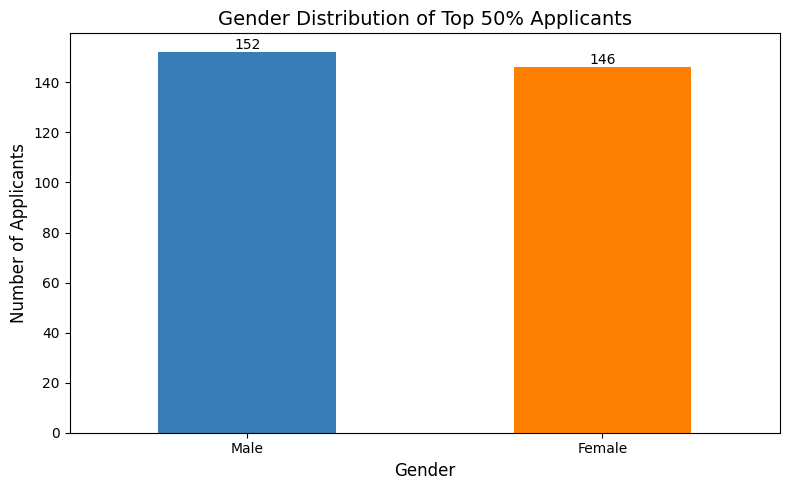

In [ ]:
gender_distribution_top_50 = top_50_percent_applicants['gender'].value_counts()

plt.figure(figsize=(8, 5))
gender_distribution_top_50.plot(kind='bar', color=['#377eb8', '#ff7f00'])

plt.title("Gender Distribution of Top 50% Applicants", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Number of Applicants", fontsize=12)
plt.xticks(rotation=0)

for i, count in enumerate(gender_distribution_top_50):
    plt.text(i, count + (0.01 * gender_distribution_top_50.max()), str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()